Install R

Then install Seurat v3.0.0 because after Seurat use reticulate (a bridge from R to Python) that crashes R

```
install.packages('devtools')
require(devtools)
install.packages("BiocManager")
BiocManager::install("multtest")
install_version(package = 'Seurat', version = package_version('3.0.0'), repos = "http://cran.us.r-project.org", dependencies=FALSE)
install_github('MacoskoLab/liger')
install_version(package = 'matrixStats',  repos = "http://cran.us.r-project.org")

# Install a JDK for Liger. Mac OS commands
brew cask install java
xattr -r -d com.apple.quarantine /Library/Java/JavaVirtualMachines/openjdk-13.0.1.jdk

```

# Extension of Basic gimVI tutorial: Reproduce GimVI results
## Impute missing genes in Spatial Data from Sequencing Data

In [1]:
import sys

sys.path.append("../../")
sys.path.append("../scVI/")
sys.path.append("../scVI/tests/")

import warnings
warnings.filterwarnings('ignore')

In [2]:
save_path = "../../data"

In [3]:
from scvi.dataset import (
    PreFrontalCortexStarmapDataset,
    FrontalCortexDropseqDataset,
    SmfishDataset,
    CortexDataset,
)
from scvi.models import JVAE, Classifier, VAE
from scvi.inference import JVAETrainer, UnsupervisedTrainer

import notebooks.utils.gimvi_tutorial as gimvi_utils

import numpy as np
import copy
import matplotlib.pyplot as plt
import time

In [4]:
from benchmarkable import Data, SeuratV3, Liger, Coral, Benchmarkable
from benchmarkable import scVI as ScVI
from plot_benchmarkable import PlotBenchmarkable

R[write to console]: During startup - 
R[write to console]: Warning messages:

R[write to console]: 1: Setting LC_COLLATE failed, using "C" 

R[write to console]: 2: Setting LC_TIME failed, using "C" 

R[write to console]: 3: Setting LC_MESSAGES failed, using "C" 

R[write to console]: 4: Setting LC_MONETARY failed, using "C" 



## Load two datasets: one with spatial data, one from sequencing

- **FrontalCortexDropseq**: a scRNA-seq dataset of 71,639 mouse frontal cortex cells (Saunders et al., 2018)
- **PreFrontalCortexStarmap**: a starMAP dataset of 3,704 cells and 166 genes from the mouse pre-frontal cortex (Wang et al., 2018)


In [5]:
data_spatial = PreFrontalCortexStarmapDataset(save_path=save_path)
data_seq = FrontalCortexDropseqDataset(
    save_path=save_path, genes_to_keep=data_spatial.gene_names
)


[2020-01-05 21:46:29,540] INFO - scvi.dataset.dataset | File /Users/anazaret/Documents/data/mpfc-starmap.loom already downloaded
[2020-01-05 21:46:29,541] INFO - scvi.dataset.loom | Preprocessing dataset
[2020-01-05 21:46:29,621] INFO - scvi.dataset.loom | Finished preprocessing dataset
[2020-01-05 21:46:29,629] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 21:46:29,631] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-05 21:46:29,634] INFO - scvi.dataset.dataset | File /Users/anazaret/Documents/data/fc-dropseq.loom already downloaded
[2020-01-05 21:46:29,635] INFO - scvi.dataset.loom | Preprocessing dataset
[2020-01-05 21:46:56,000] INFO - scvi.dataset.loom | Finished preprocessing dataset
[2020-01-05 21:47:11,824] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 21:47:11,827] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-05 21:47:12,488] INFO - scvi.dataset.dataset | Computing the library size f

In [6]:
# Subsample cells
np.random.seed(10)
cells = np.random.choice(np.arange(data_seq.X.shape[0]), 15000, replace=False)
data_seq.update_cells(cells)

[2020-01-05 21:47:12,643] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,651] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2020-01-05 21:47:12,653] INFO - scvi.dataset.dataset | Downsampled from 71639 to 15000 cells


**Hide some genes in the osFISH dataset to score the imputation**

In [7]:
data_seq.filter_cells_by_count(1)
data_spatial.filter_cells_by_count(1)
data_seq.filter_genes_by_count(1)
data_spatial.filter_cells_by_count(1)

[2020-01-05 21:47:12,666] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,671] INFO - scvi.dataset.dataset | Downsampled from 15000 to 14997 cells
[2020-01-05 21:47:12,682] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,688] INFO - scvi.dataset.dataset | Downsampled from 3704 to 3704 cells
[2020-01-05 21:47:12,692] INFO - scvi.dataset.dataset | Downsampling from 158 to 156 genes
[2020-01-05 21:47:12,705] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,716] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-05 21:47:12,729] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,734] INFO - scvi.dataset.dataset | Downsampled from 14997 to 14997 cells
[2020-01-05 21:47:12,738] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,741] INFO - scvi.dat

In [8]:
data_spatial.filter_genes_by_attribute(data_seq.gene_names)

[2020-01-05 21:47:12,748] INFO - scvi.dataset.dataset | Downsampling from 158 to 156 genes
[2020-01-05 21:47:12,750] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,754] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-05 21:47:12,756] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,759] INFO - scvi.dataset.dataset | Downsampled from 3704 to 3704 cells


In [9]:
train_size = 0.8

gene_names_rnaseq = data_seq.gene_names
np.random.seed(0)
n_genes = len(gene_names_rnaseq)
gene_ids_train = sorted(
    np.random.choice(range(n_genes), int(n_genes * train_size), False)
)
gene_ids_test = sorted(set(range(n_genes)) - set(gene_ids_train))

gene_names_fish = gene_names_rnaseq[gene_ids_train]

# Create copy of the fish dataset with hidden genes
data_spatial_partial = copy.deepcopy(data_spatial)
data_spatial_partial.filter_genes_by_attribute(gene_names_fish)
data_spatial_partial.batch_indices += data_seq.n_batches

[2020-01-05 21:47:12,770] INFO - scvi.dataset.dataset | Downsampling from 156 to 124 genes
[2020-01-05 21:47:12,774] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,777] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-05 21:47:12,781] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,785] INFO - scvi.dataset.dataset | Downsampled from 3704 to 3704 cells


In [10]:
data_seq.initialize_cell_attribute("original_id", list(range(data_seq.nb_cells)))
tmp = copy.deepcopy(data_seq)
tmp.filter_genes_by_attribute(gene_names_fish)
data_seq.filter_cells_by_attribute(values_to_keep=tmp.original_id, on="original_id")

[2020-01-05 21:47:12,861] INFO - scvi.dataset.dataset | Downsampling from 156 to 124 genes
[2020-01-05 21:47:12,873] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,884] WARNING - scvi.dataset.dataset | This dataset has some empty cells, this might fail scVI inference.Data should be filtered with `my_dataset.filter_cells_by_count()
[2020-01-05 21:47:12,886] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-01-05 21:47:12,900] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,906] INFO - scvi.dataset.dataset | Downsampled from 14997 to 14978 cells
[2020-01-05 21:47:12,924] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:12,931] INFO - scvi.dataset.dataset | Downsampled from 14997 to 14978 cells


In [11]:
data = Data(data_seq, data_spatial, data_spatial_partial, gene_ids_train, gene_ids_test)

# Benchmark against SeuratAnchors, Liger, Coral

## We binded the packages with their official R code
The algorithms are wrapped into the `Benchmarkable` class which has methods: `train`, `compute`, `benchmark` and also `save` to dump the object after a long training.

In [12]:
# Name is SeuratSM (for StarMap) which was for 5.000 cells 
# then I used 15.000 cells and then I noticed subsample_cells was not random (taking higher variance)
# so SeuratSM15Random is 15.000 random cells

In [13]:
seurat = SeuratV3(data, "SeuratSM15Random", 8)
liger = Liger(data, "LigerSM15Random", 8)
coral = Coral(data, "CoralSM15Random", 8)
scVI = ScVI(data, "scVISM15Random", 8)

R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Performing log-normalization

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[wri

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: |

R[write to console]: Centering and scaling data matrix

  |                                                                            
  |         

[2020-01-05 21:47:22,508] INFO - scvi.dataset.dataset | Keeping 124 genes
[2020-01-05 21:47:22,509] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:22,513] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 21:47:22,514] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-05 21:47:22,527] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-01-05 21:47:22,536] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 21:47:22,537] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-01-05 21:47:22,556] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-01-05 21:47:22,558] INFO - scvi.dataset.dataset | Remapping labels to [0,N]


In [14]:
seurat.train()
seurat.compute()
seurat.benchmark()
seurat.save()

R[write to console]: Computing 2000 integration features

R[write to console]: Scaling features for provided objects

R[write to console]: Finding all pairwise anchors

R[write to console]: Running CCA

R[write to console]: Merging objects

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 14275 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 1362 anchors

R[write to console]: Extracting within-dataset neighbors

R[write to console]: Merging dataset 1 into 2

R[write to console]: Extracting anchors for merged samples

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to 

PC_ 1 
Positive:  gene-53, gene-57, gene-19, gene-86, gene-38, gene-97, gene-27, gene-12, gene-6, gene-3 
	   gene-63, gene-40, gene-5, gene-64, gene-96, gene-117, gene-65, gene-43, gene-100, gene-33 
	   gene-81, gene-111, gene-83, gene-102, gene-2, gene-45, gene-82, gene-120, gene-41, gene-118 
Negative:  gene-52, gene-34, gene-51, gene-4, gene-44, gene-60, gene-123, gene-72, gene-68, gene-9 
	   gene-78, gene-84, gene-116, gene-103, gene-15, gene-71, gene-28, gene-1, gene-13, gene-58 
	   gene-91, gene-109, gene-59, gene-67, gene-17, gene-29, gene-113, gene-26, gene-7, gene-99 
PC_ 2 
Positive:  gene-96, gene-119, gene-49, gene-66, gene-75, gene-118, gene-42, gene-36, gene-121, gene-5 
	   gene-97, gene-4, gene-102, gene-31, gene-38, gene-72, gene-37, gene-82, gene-58, gene-1 
	   gene-2, gene-45, gene-77, gene-106, gene-120, gene-25, gene-13, gene-124, gene-99, gene-122 
Negative:  gene-111, gene-52, gene-51, gene-33, gene-89, gene-101, gene-84, gene-113, gene-60, gene-65 
	   gene

R[write to console]: Performing PCA on the provided reference using 156 features as input.

R[write to console]: Projecting PCA

R[write to console]: Finding neighborhoods

R[write to console]: Finding anchors

R[write to console]: 	Found 2970 anchors

R[write to console]: Filtering anchors

R[write to console]: 	Retained 1406 anchors

R[write to console]: Extracting within-dataset neighbors

R[write to console]: Finding integration vectors

R[write to console]: Finding integration vector weights

R[write to console]: 0%   10   20   30   40   50   60   70   80   90   100%

R[write to console]: [----|----|----|----|----|----|----|----|----|----|

R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R[write to console]: *
R

In [15]:
liger.train()
liger.compute()
liger.benchmark()
liger.save()

8
  |======================================================================| 100%
Converged in 22.10472 secs, 21 iterations.
  |======================================================================| 100%
Converged in 24.87042 secs, 25 iterations.
  |======================================================================| 100%
Converged in 28.79187 secs, 27 iterations.
Best results with seed 3.
[1] "Recomputing shared nearest factor space"
[1] "making edge file."
[1] "Starting SLM"
[1] "Assigning singletons"


In [16]:
coral.train()
coral.compute()
coral.benchmark_imputation()
coral.save()

In [17]:
scVI.train()
scVI.compute()
scVI.benchmark()
scVI.save()

**Configure the Joint Model**
The joint model can take multiple datasets with potentially different observed genes. 
All dataset will be encoded and decoded with the union of all genes.
It requires:
- The gene mappings from each dataset to the common decoded vector:
    * *Eg: dataset1 has genes ['a', 'b'] and dataset2 has genes ['b', 'c'], then a possible output can be ['b', 'a', 'c'] such that the mappings are [1, 0] and [0, 2]*
    * *Usually, if the genes of dataset2 are included in dataset1, it is way more efficient to keep the order of dataset1 in the output and use `slice(None)` as a mapping for dataset1*
    
- The number of inputs (ie) number of genes in each dataset
- The distributions to use for the generative process: usually scRNA-seq is modelled with ZINB (because of technical dropout) and FISH with NB or even Poisson
- Whether to model the library size with a latent variable or use the observed value

In [18]:
datasets = [data_seq, data_spatial_partial]
generative_distributions = ["zinb", "nb"]
gene_mappings = [slice(None), np.array(gene_ids_train)]
n_inputs = [d.nb_genes for d in datasets]
total_genes = data_seq.nb_genes
n_batches = sum([d.n_batches for d in datasets])

model_library_size = [True, False]

n_latent = 8
kappa = 5

In [19]:
import torch

torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dim_hidden_decoder_shared=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)
discriminator = Classifier(n_latent, 32, 2, 3, logits=True)
trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

In [20]:
class GimVI(Benchmarkable):
    def __init__(self, data, name, trainer):
        super().__init__(data, name)
        self.trainer_both = trainer
        self.n_latent = self.trainer_both.model.n_latent

    def train_fish(self, n_epochs=100):
        dataset = self.data.data_fish
        vae = VAE(
            dataset.nb_genes,
            n_batch=dataset.n_batches,
            dispersion="gene-batch",
            n_latent=self.n_latent,
            reconstruction_loss="nb",
        )
        self.trainer_fish = UnsupervisedTrainer(
            vae, dataset, train_size=0.95, use_cuda=False
        )
        self.trainer_fish.train(n_epochs=n_epochs, lr=0.001)

    def train_seq(self, n_epochs=100):
        dataset = self.data.data_seq
        vae = VAE(dataset.nb_genes, dispersion="gene", n_latent=self.n_latent)
        self.trainer_seq = UnsupervisedTrainer(
            vae, dataset, train_size=0.95, use_cuda=False
        )
        self.trainer_seq.train(n_epochs=n_epochs, lr=0.001)

    def train_both(self, n_epochs=100):
        starting_time = time.time()
        self.trainer_both.train(n_epochs=n_epochs)
        self.posterior_both = self.trainer_both.create_posterior()
        self.train_time = time.time() - starting_time

        
    def compute_latent(self):
        self.latent_both_seq, self.latent_both_fish = self.trainer_both.get_latent()

        fish = self.trainer_fish.create_posterior().get_latent()[0]
        self.latent_only_fish = fish

        seq = self.trainer_seq.create_posterior().get_latent()[0]
        self.latent_only_seq = seq

        return (
            self.latent_both_fish,
            self.latent_both_seq,
            self.latent_only_fish,
            self.latent_only_seq,
        )

    def compute_imputed_values(self):
        _, self.imputed_full = self.trainer_both.get_imputed_values(normalized=False)
        self.imputed = self.imputed_full[:, self.data.test_indices]
        return self.imputed

In [21]:
gimvi = GimVI(data, "GimVISM15Random-kappa5", trainer)
gimvi.train_seq(100)
gimvi.train_fish(100)
gimvi.train_both(100)
gimvi.compute()
gimvi.benchmark()
gimvi.save()


training: 100%|██████████| 100/100 [09:34<00:00,  5.74s/it]


In [22]:
kappa = 0
torch.manual_seed(0)

model = JVAE(
    n_inputs,
    total_genes,
    gene_mappings,
    generative_distributions,
    model_library_size,
    n_layers_decoder_individual=0,
    n_layers_decoder_shared=0,
    n_layers_encoder_individual=1,
    n_layers_encoder_shared=1,
    dim_hidden_encoder=64,
    dim_hidden_decoder_shared=64,
    dropout_rate_encoder=0.2,
    dropout_rate_decoder=0.2,
    n_batch=n_batches,
    n_latent=n_latent,
)

discriminator = Classifier(n_latent, 32, 2, 3, logits=True)

trainer = JVAETrainer(model, discriminator, datasets, 0.95, frequency=1, kappa=kappa)

gimvi = GimVI(data, "GimVISM15Random-kappa0", trainer)
gimvi.train_seq(100)
gimvi.train_fish(100)
gimvi.train_both(100)
gimvi.compute()
gimvi.benchmark()

gimvi.save()


training: 100%|██████████| 100/100 [05:35<00:00,  3.36s/it]


## Here are the plots reproducing the results in the paper: 
[A joint model of unpaired data from scRNA-seq and spatial transcriptomics for imputing missing gene expression measurements](https://arxiv.org/abs/1905.02269)

In [23]:
%matplotlib inline

In [45]:
plt.rcParams["figure.figsize"] = [16, 8]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
plt.rcParams['font.size'] =10

We load the model previously trained.

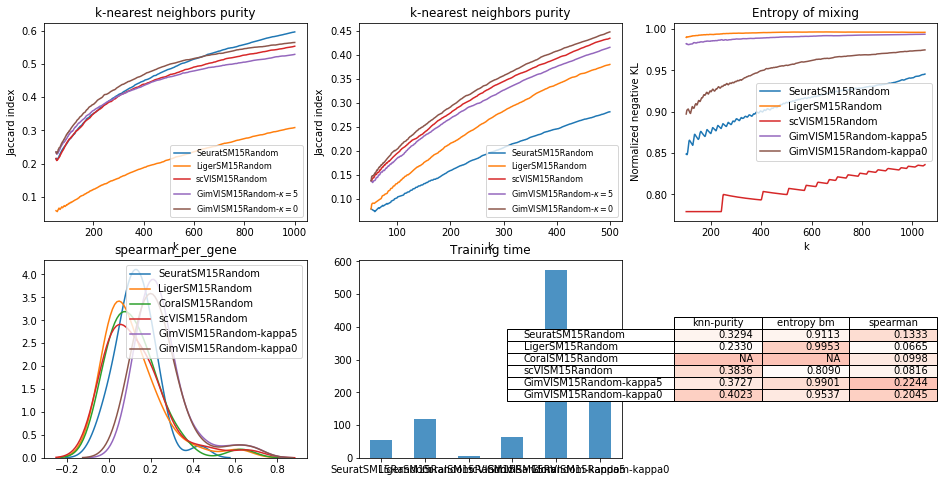

In [46]:
pb = PlotBenchmarkable(
    [
        Benchmarkable.load("SeuratSM15Random"),
        Benchmarkable.load("LigerSM15Random"),
        Benchmarkable.load("CoralSM15Random"),
        Benchmarkable.load("scVISM15Random"),
        Benchmarkable.load("GimVISM15Random-kappa5"),
        Benchmarkable.load("GimVISM15Random-kappa0"),
    ]
)
pb.MAX_KNN = 1000
pb.plot()

# Uncertainty

In [27]:
import seaborn as sns

In [28]:
model = Benchmarkable.load("GimVISM15Random-kappa5")

In [49]:
from sklearn.linear_model import LinearRegression

samples = np.array(
    [
        model.trainer_both.get_imputed_values(False)[1][:, model.data.test_indices]
        for _ in range(50)
    ]
)
uncertainty = np.std(samples, axis=0).mean(axis=0)
means = np.mean(samples, axis=0).mean(axis=0)

data_seq_normalized = np.log(
    1
    + 10 ** 4
    * model.data.data_seq.X
    / model.data.data_seq.X.sum(axis=1).reshape((-1, 1))
)
X = data_seq_normalized[:, model.data.train_indices]
Y = data_seq_normalized[:, model.data.test_indices]

lr = LinearRegression(normalize=False)
lr.fit(X, Y)

mse = (lr.predict(X) - Y) ** 2
gene_rmse = mse.mean(axis=0) ** 0.5

# Proxy for the correlation measure of test gene to train genes

# Relative error
imputation_me = (
    (model.data.data_fish.X[:, model.data.test_indices] - model.imputed)
    / (model.data.data_fish.X[:, model.data.test_indices] + 1)
).mean(axis=0)

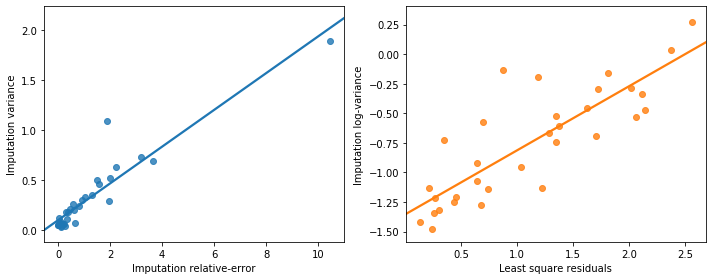

In [30]:
import seaborn as sns
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.regplot(np.abs(imputation_me), (uncertainty/samples.mean()), ci=0, ax=axes[0])
#axes[0].set_ylim((-8, -5))
axes[0].set_xlabel('Imputation relative-error')
axes[0].set_ylabel('Imputation variance')


sns.regplot(gene_rmse, np.log10(uncertainty/samples.mean()), ci=0, ax=axes[1])
#axes[1].set_ylim((-8, -5))
axes[1].set_xlabel('Least square residuals')
axes[1].set_ylabel('Imputation log-variance')
plt.tight_layout()
#@plt.savefig('uncertainty-starmap.pdf')